# Истинная орбита МКС - фильтр Калмана

Задача состоит в определении положения и скорости международной космической станции на орбите с наибольшей возможной точностью путём построения алгоритма фильтра Калмана. Движение станции использует ограниченную модель 2 тел и описывается классическими ньютоновскими уравнениями с добавкой второго порядка, вызванной несферичностью Земли. На вход поступают измеренные в текущий момент векторы координат и скорости станции (в моделировании данные берутся из файла "iss_test.txt"). Измерения производятся с погрешностью. Требуется, используя модель и получаемые измерения определять положение и движение МКС в любой момент времени. Для тестовой задачи дан промежуток времени длиной примерно 1 час 40 минут. 
Параметры для задачи:

$ \mu = 3.99^{5} {{\text{км}^3} \over {\text{с}^2}} $ - гравитационный параметр, 
$ R = 6371.137 $ км - радиус Земли, 
$ J_2 = 0.0010827 $ - вторая зональная гармоника геопотенциала,

Ошибка измерения фазовых переменных станции (данные взяты из статьи https://iopscience.iop.org/article/10.1088/1757-899X/211/1/012015):
$ \sigma^2_x = 100 \ \text{м}^2 $ - дисперсия координаты, 
$ \sigma^2_v = 10^{-4} \ {{\text{м}} \over {\text{с}}} $ - дисперсия скорости

В задаче вводится вектор состояния, состоящий из фазовых переменных МКС:
$$ \vec{x} =  \left[
  \begin{array}{ccc}
     \vec r \\
     \vec v \\
  \end{array}
\right] = \left[
  \begin{array}{ccc}
     x \\
     y \\
     z \\
     v_x \\
     v_y \\
     v_z \\
  \end{array}
\right] $$

Производные вектора состояния задаются уравнениями:
$$ \dot{\vec{x}} = \left[
  \begin{array}{ccc}
     v_x \\
     v_y \\
     v_z \\
     - {{{\mu x} \over {r^3}} + {{\mu J_2 R^2} \over {2}} ({15 {xz^2} \over {r^7}} - {3 x \over {r^5}})} \\
     - {{{\mu y} \over {r^3}} + {{\mu J_2 R^2} \over {2}} ({15 {yz^2} \over {r^7}} - {3 y \over {r^5}})} \\
     - {{{\mu z} \over {r^3}} + {{\mu J_2 R^2} \over {2}} ({15 {z^3} \over {r^7}} - {9 z \over {r^5}})} \\
  \end{array}
\right] $$

## Алгоритм решения

Общая модель системы (нелинейного процесса):
$$\begin{cases}
\dot{x} = f(x, u, t) + w(t) \\
\dot{z} = h(x) + v(t) \text{,}
\end{cases}$$
где $ f(x, u, t) $ - функция модели состояния системы, $ h(x) $ - функция модели измерений,
а $ w(t) $ и $ v(t) $, соответственно, ошибки модели состояния и модели наблюдения.

В данной задаче отсутствует управление, а также уравнения движения небесного тела зависят только от фазовых координат,
поэтому $ f(x, u, t) = f(x) $, а величина ошибок постоянна во времени, поэтому $ v(t) = v $, $ w(t) = w $.
Таким образом, модель системы упрощается до вида:
$$\begin{cases}
\dot{x} = f(x) + w \\
z = h(x) + v
\end{cases}$$

Задача от дискретных переменных выглядит следующим образом:
$$\begin{cases}
x_k = x_{k-1} + f(x_{k-1}) + w_k \\
z_k = h(x_k) + v_k 
\end{cases}$$

Будем обозначать:
$ x_k, P_k $ - истинное состояние системы и матрица ковариаций ошибок,
$ \hat{x_k}, \hat{P_k} $ - оценка состояния системы и матрицы ковариаций ошибок,
$ \overline{x_k}, \overline{P_k} $ - оценка вектора состояния и матрицы ковариаций ошибок по модели.

##### Задача решается в 2 этапа: предиктор и корректор

### Предиктор:
Первым этапом делается прогноз состояния системы по используемым уравнениям модели.
Прогноз (экстраполяция) вектора состояния и матрицы ковариаций ошибок с помощью модели процесса:
$$ \overline{x_k} = \hat{x_k} + \int_{t_{k-1}}^{t_k}f(x(t))dt $$

$$ \overline{P_k} = \Phi \cdot \hat{P_k} \cdot \Phi^T + Q \ \text{, где } $$

$$ \Phi = E + F \cdot (t_k - t_{k-1}) $$

$$ F = \frac{\partial f}{\partial x} \bigg|_{x = \tilde{x_{k-1}}} - \text{якобиан функции состояния модели} $$
$$ Q = E [w_k \cdot w_k^T] - \text{матрица ковариации шумов модели системы} $$
Для данной задачи якобиан функции состояния модели выглядит следующим образом:
$$ F = F(\tilde x) = \begin{bmatrix}
O_{3x3} &I_{3x3}\\
\Phi_{33} &O_{3x3}
\end{bmatrix}, \ \ \ \ \ \
\Phi_{33} = \begin{bmatrix}
- {{\mu} \over {r^3}} + {\mu J_2 R^2 \over 2} ({{15 z^2} \over r^7} - {3 \over r^5})  & 0 & \mu J_2 R^2 {15 xz} \over r^7 \\
0 & - {{\mu} \over {r^3}} + {\mu J_2 R^2 \over 2} ({{15 z^2} \over r^7} - {3 \over r^5}) & \mu J_2 R^2 {15 yz} \over r^7 \\
0 & 0 & {-\mu \over {r^3}} + {{3 \mu J_2 R^2} \over 2} ({{15 z^2} \over r^7} - {9 \over r^5})
\end{bmatrix}$$

### Корректор:
Вторым этапом полученные значения корректируются с помощью измеренных данных о состоянии модели
Вычисление коэффициента усиления Калмана:
$$ K = \overline{P}_k \cdot H^T \cdot \left(H\cdot \overline{P}_k\cdot H^T + R\right)^{-1} $$
Оценка вектора состояния и матрицы ковариации ошибок:
$$\hat{x}_k = \overline{x}_k + K \cdot\left(z_k - H\cdot\overline{x}_k\right)$$
$$\hat{P}_k = \left(I - K\cdot H\right)\cdot \overline{P}_k \ \text{, где}$$
$$ H = \frac{\partial f}{\partial x} \bigg|_{x = \tilde{x_{k}}} - \text{якобиан функции измерения модели} $$
$$ R = E [v_k \cdot v_k^T] - \text{матрица ковариации шумов модели наблюдения} $$
Для данной задачи якобиан функции измерения модели $ H \equiv I_{6x6} $

## Импорт необходимых библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
from scipy.integrate import solve_ivp
import scipy.stats as st
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
from numpy.linalg import norm

## Функции

In [2]:
def FuncOrbite(t, x): # Функция f(x, t)
    r = np.copy(x[:3])
    r_abs = np.linalg.norm(r)
    v = np.copy(x[3:])
    second_order = (np.array([r[0]*r[2]**2, r[1]*r[2]**2, r[2]**3]) * 15 / r_abs**7 -
                    np.array([3*r[0], 3*r[1], 9*r[2]]) / r_abs**5) * mu * J2 * R**2 / 2 
    return np.concatenate((v, -mu * r / r_abs**3 + second_order), axis=0)

def FuncMeasure(x): # Функция h(x)
    return x

def ModelError(t): # Функция шума модели состояния. Функция может быть любой, но ограниченной
    rng = np.random.default_rng()
    return np.append(Ampl_w_r * rng.standard_normal(3), Ampl_w_v * rng.standard_normal(3))

def MeasureError(t): # Функция шума модели наблюдения. Функция может быть любой, но ограниченной
    rng = np.random.default_rng()
    return np.append(Ampl_v_r * rng.standard_normal(3), Ampl_v_v * rng.standard_normal(3))

def JacobianF(x):
    r = np.copy(x[:3])
    r_abs = np.linalg.norm(r)
    Phi = np.zeros((6,6))
    Phi[0:3, 3:6] = np.eye(3)
    a = mu * J2 * R**2 / 2 * (15 * r[2]**2 / r_abs**7 - 3 / r_abs**5)
    b = 15 * mu * J2 * R**2 / r_abs**7 * r[2]
    Phi[3, 0] = -mu / r_abs**3 + a
    Phi[4, 1] = -mu / r_abs**3 + a
    Phi[5, 2] = -mu / r_abs**3 + 3*a
    Phi[3, 2] = b * r[0]
    Phi[4, 2] = b * r[1]
    return Phi

def JacobianH(x):
    return np.eye(6)

def time(str_t):
    A = str_t.split(':')
    for i in range(len(A)):
        if A[i][0:2] == '00':
            if len(A[i]) <= 2:
                A[i] = '0'
            else:
                A[i] = '0' + A[i][2:]
    return int(A[0]) * 3600 + int(A[1]) * 60 + float(A[2])

## Расширенный фильтр Калмана

### Предиктор

In [3]:
def predictorStatus(xk_1, tk_1, tk):
    sol = solve_ivp(FuncOrbite, [tk_1, tk], xk_1, method='LSODA', atol=Ampl_w_r, rtol=(Ampl_w_v / 1)) # Интегрируем уравнение движения от tk_1 до tk
    xk_predicted = sol.y[:, -1]
    return xk_predicted

def predictorCovar(Pk_1, xk_1, tk_1, tk):
    dt = tk - tk_1
    Phi = np.eye(6) + JacobianF(xk_1) * dt
    wk = ModelError(tk_1)
    Q = np.diag(wk**2) # Матрица ковариаций шумов модели
    Pk_estimated = Phi @ Pk_1 @ Phi.T + Q
    return Pk_estimated

### Корректор

In [4]:
def MatrixK(Pk_estimated, xk_predicted, tk):
    vk = MeasureError(tk)
    R = np.diag(vk**2) # Матрица ковариаций шумов измерений
    H = JacobianH(xk_predicted)
    
    K = Pk_estimated @ H.T @ np.linalg.inv(H @ Pk_estimated @ H.T + R)
    return K

def correctorStatus(xk_predicted, zk, K):
    xk = xk_predicted + K @ (zk - FuncMeasure(xk_predicted))
    return xk

def correctorCovar(Pk_estimated, xk, K):
    Pk = (np.eye(6) - K @ JacobianH(xk)) @ Pk_estimated
    return Pk

## Параметры

In [5]:
mu = 3.986004418e5
J2 = 0.0010827
R = 6378.137

# Параметры для w(t) - погрешности модели:
Ampl_w_r = 1e-2
Ampl_w_v = 1e-5

# Параметры для v(t) - погрешности измерения:
Ampl_v_r = 1e-2
Ampl_v_v = 1e-5

## Рабочая область

In [6]:
data = pd.read_csv("iss_test.txt", delim_whitespace=True) # Данные истинного состояния (xk)
N = len(data.iloc[:,0])
x = np.array(data.iloc[0, 1:])
P = np.diag([Ampl_w_r, Ampl_w_r, Ampl_w_r, Ampl_w_v, Ampl_w_v, Ampl_w_v])
status = data.copy(deep=True) # Данные состояния по фильтру Калмана (xk с крышкой)
prediction = data.copy(deep=True) # Данные модели (xk с чертой)
measure = data.copy(deep=True) # Данные измерений (z)
for i in range(1, data.shape[0]):
    t_curr = time(data.iloc[i, 0])
    t_prev = time(data.iloc[i-1, 0])
    x_pred = predictorStatus(x, t_prev, t_curr)
    P_est = predictorCovar(P, x, t_prev, t_curr)
    K = MatrixK(P_est, x_pred, t_curr)
    z = np.array(data.iloc[i, 1:]) + MeasureError(t_curr)
    #x = x_pred
    x = correctorStatus(x_pred, z, K)
    P = correctorCovar(P_est, x, K)
    status.iloc[i, 1:] = x
    prediction.iloc[i, 1:] = x_pred
    measure.iloc[i, 1:] = z

# Поиск максимальной ошибки
max_norm = [0, 0, 0, 0, 0, 0] # 1 и 2 элементы - норма между оценкой состоянием и предсказанием координат и скоростей
                              # 3 и 4 элементы - норма между оценкой состоянием и измерением координат и скоростей
                              # 5 и 6 элементы - норма между состоянием и оценкой состояния
for i in range(N):
    if norm(status.iloc[i, 1:4] - prediction.iloc[i, 1:4]) > max_norm[0]:
        max_norm[0] = norm(status.iloc[i, 1:4] - prediction.iloc[i, 1:4])
    if norm(status.iloc[i, 1:4] - measure.iloc[i, 1:4]) > max_norm[2]:
        max_norm[2] = norm(status.iloc[i, 1:4] - measure.iloc[i, 1:4])
    if norm(status.iloc[i, 1:4] - data.iloc[i, 1:4]) > max_norm[4]:
        max_norm[4] = norm(status.iloc[i, 1:4] - data.iloc[i, 1:4])
    if norm(status.iloc[i, 4:] - prediction.iloc[i, 4:]) > max_norm[1]:
        max_norm[1] = norm(status.iloc[i, 4:] - prediction.iloc[i, 4:])
    if norm(status.iloc[i, 4:] - measure.iloc[i, 4:]) > max_norm[3]:
        max_norm[3] = norm(status.iloc[i, 4:] - measure.iloc[i, 4:])
    if norm(status.iloc[i, 4:] - data.iloc[i, 4:]) > max_norm[5]:
        max_norm[5] = norm(status.iloc[i, 4:] - data.iloc[i, 4:])

## Отображение результатов:

Y-coordinate from time:
1  Jan  2000       0.000000
        2000       4.703223
        2000       9.433613
        2000      14.148424
        2000      18.861515
                   ...     
        2000    1902.122466
        2000    1906.311843
        2000    1910.510084
        2000    1914.681363
        2000    1918.877958
Name: DefaultSC.EarthMJ2000Eq.Y, Length: 6001, dtype: float64


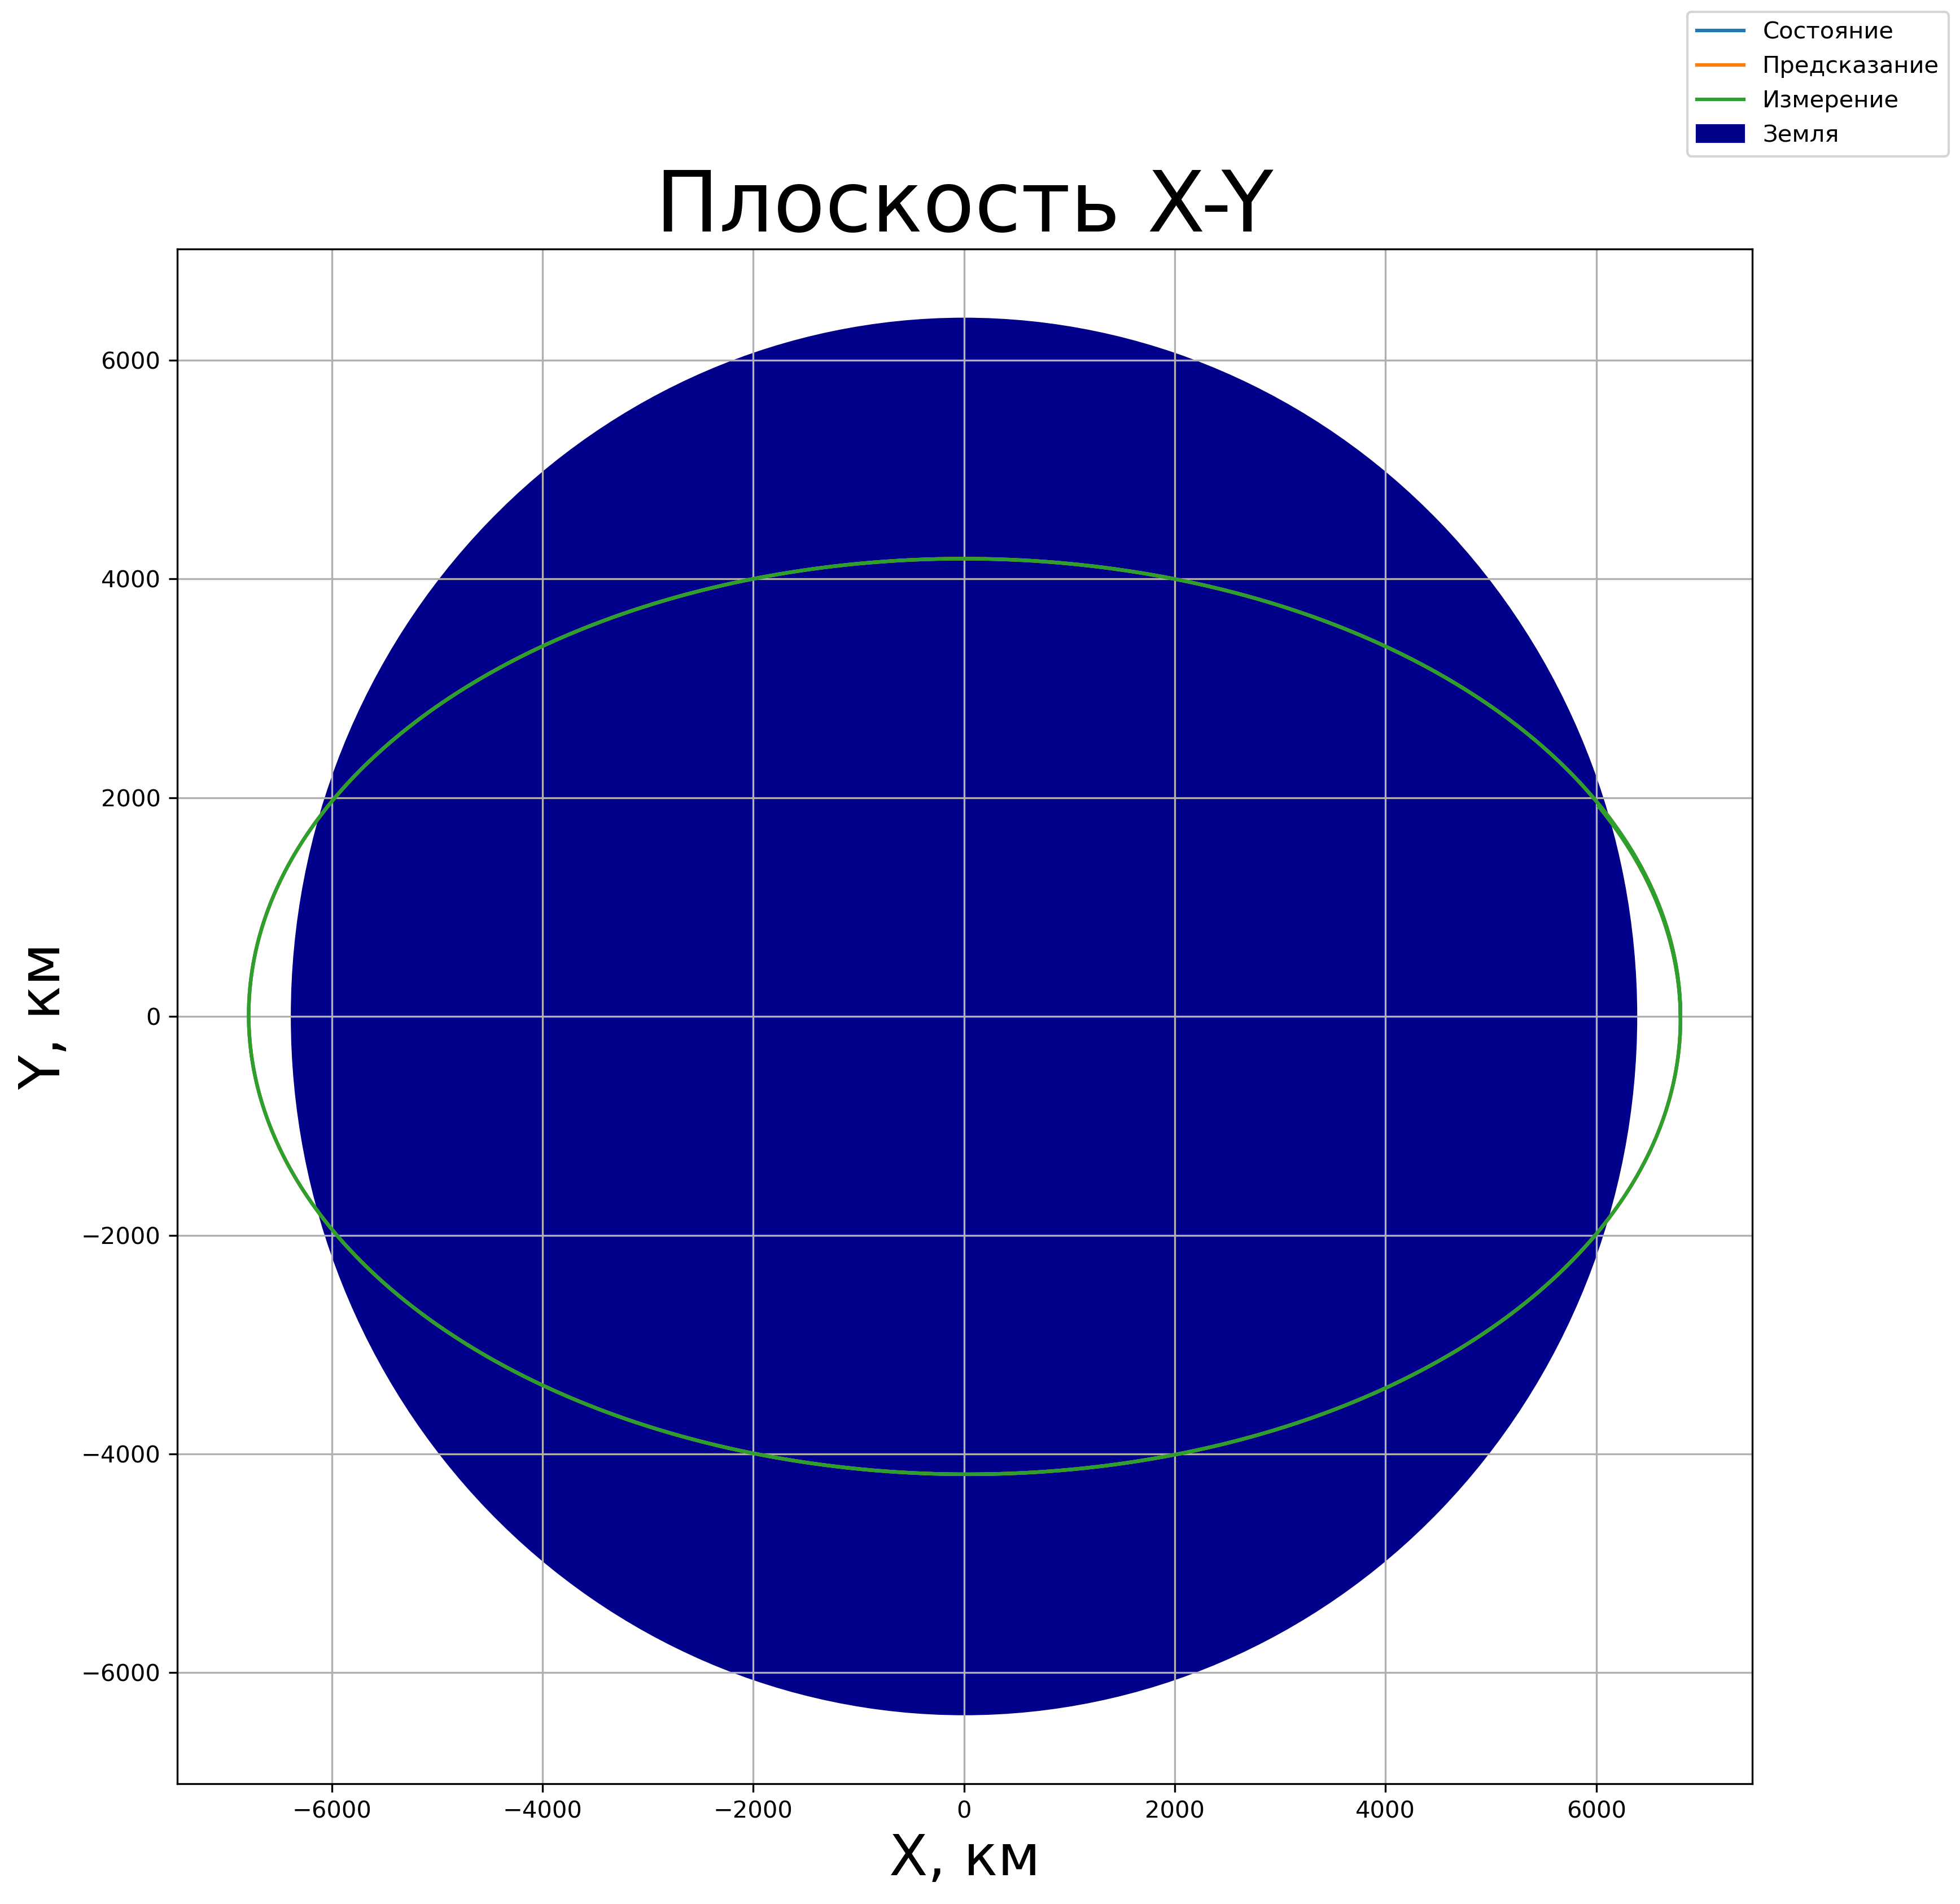

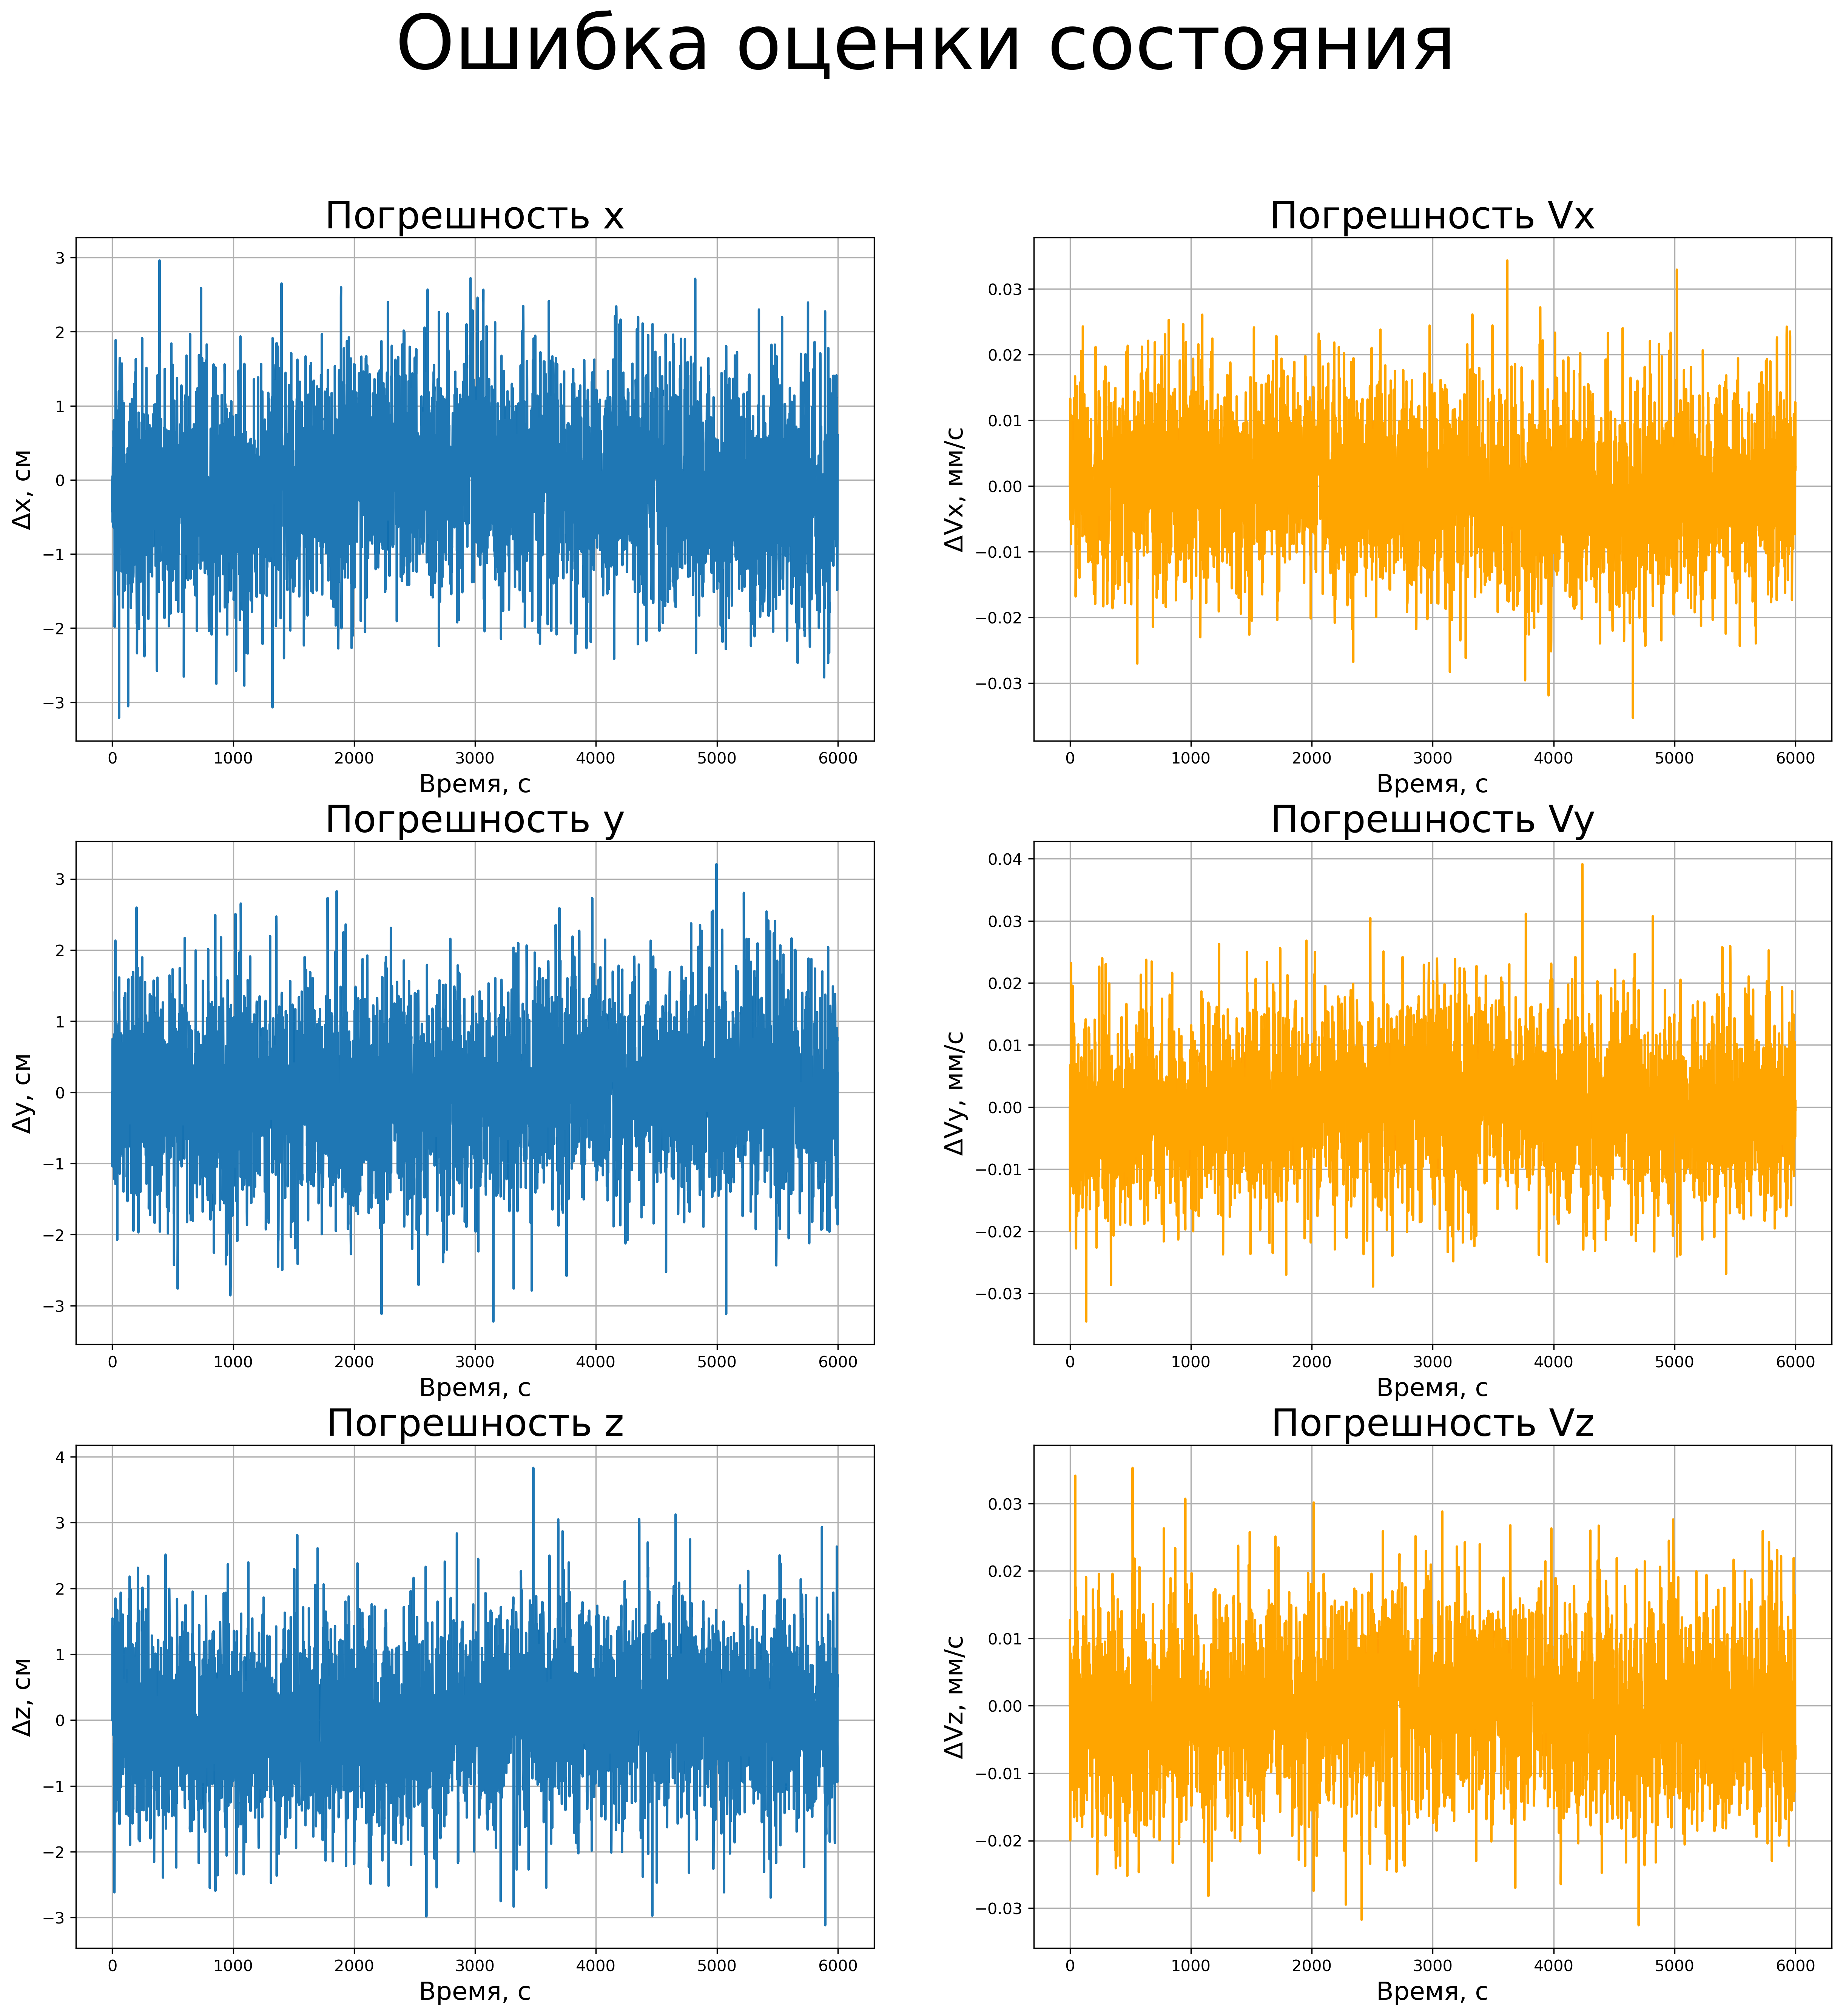

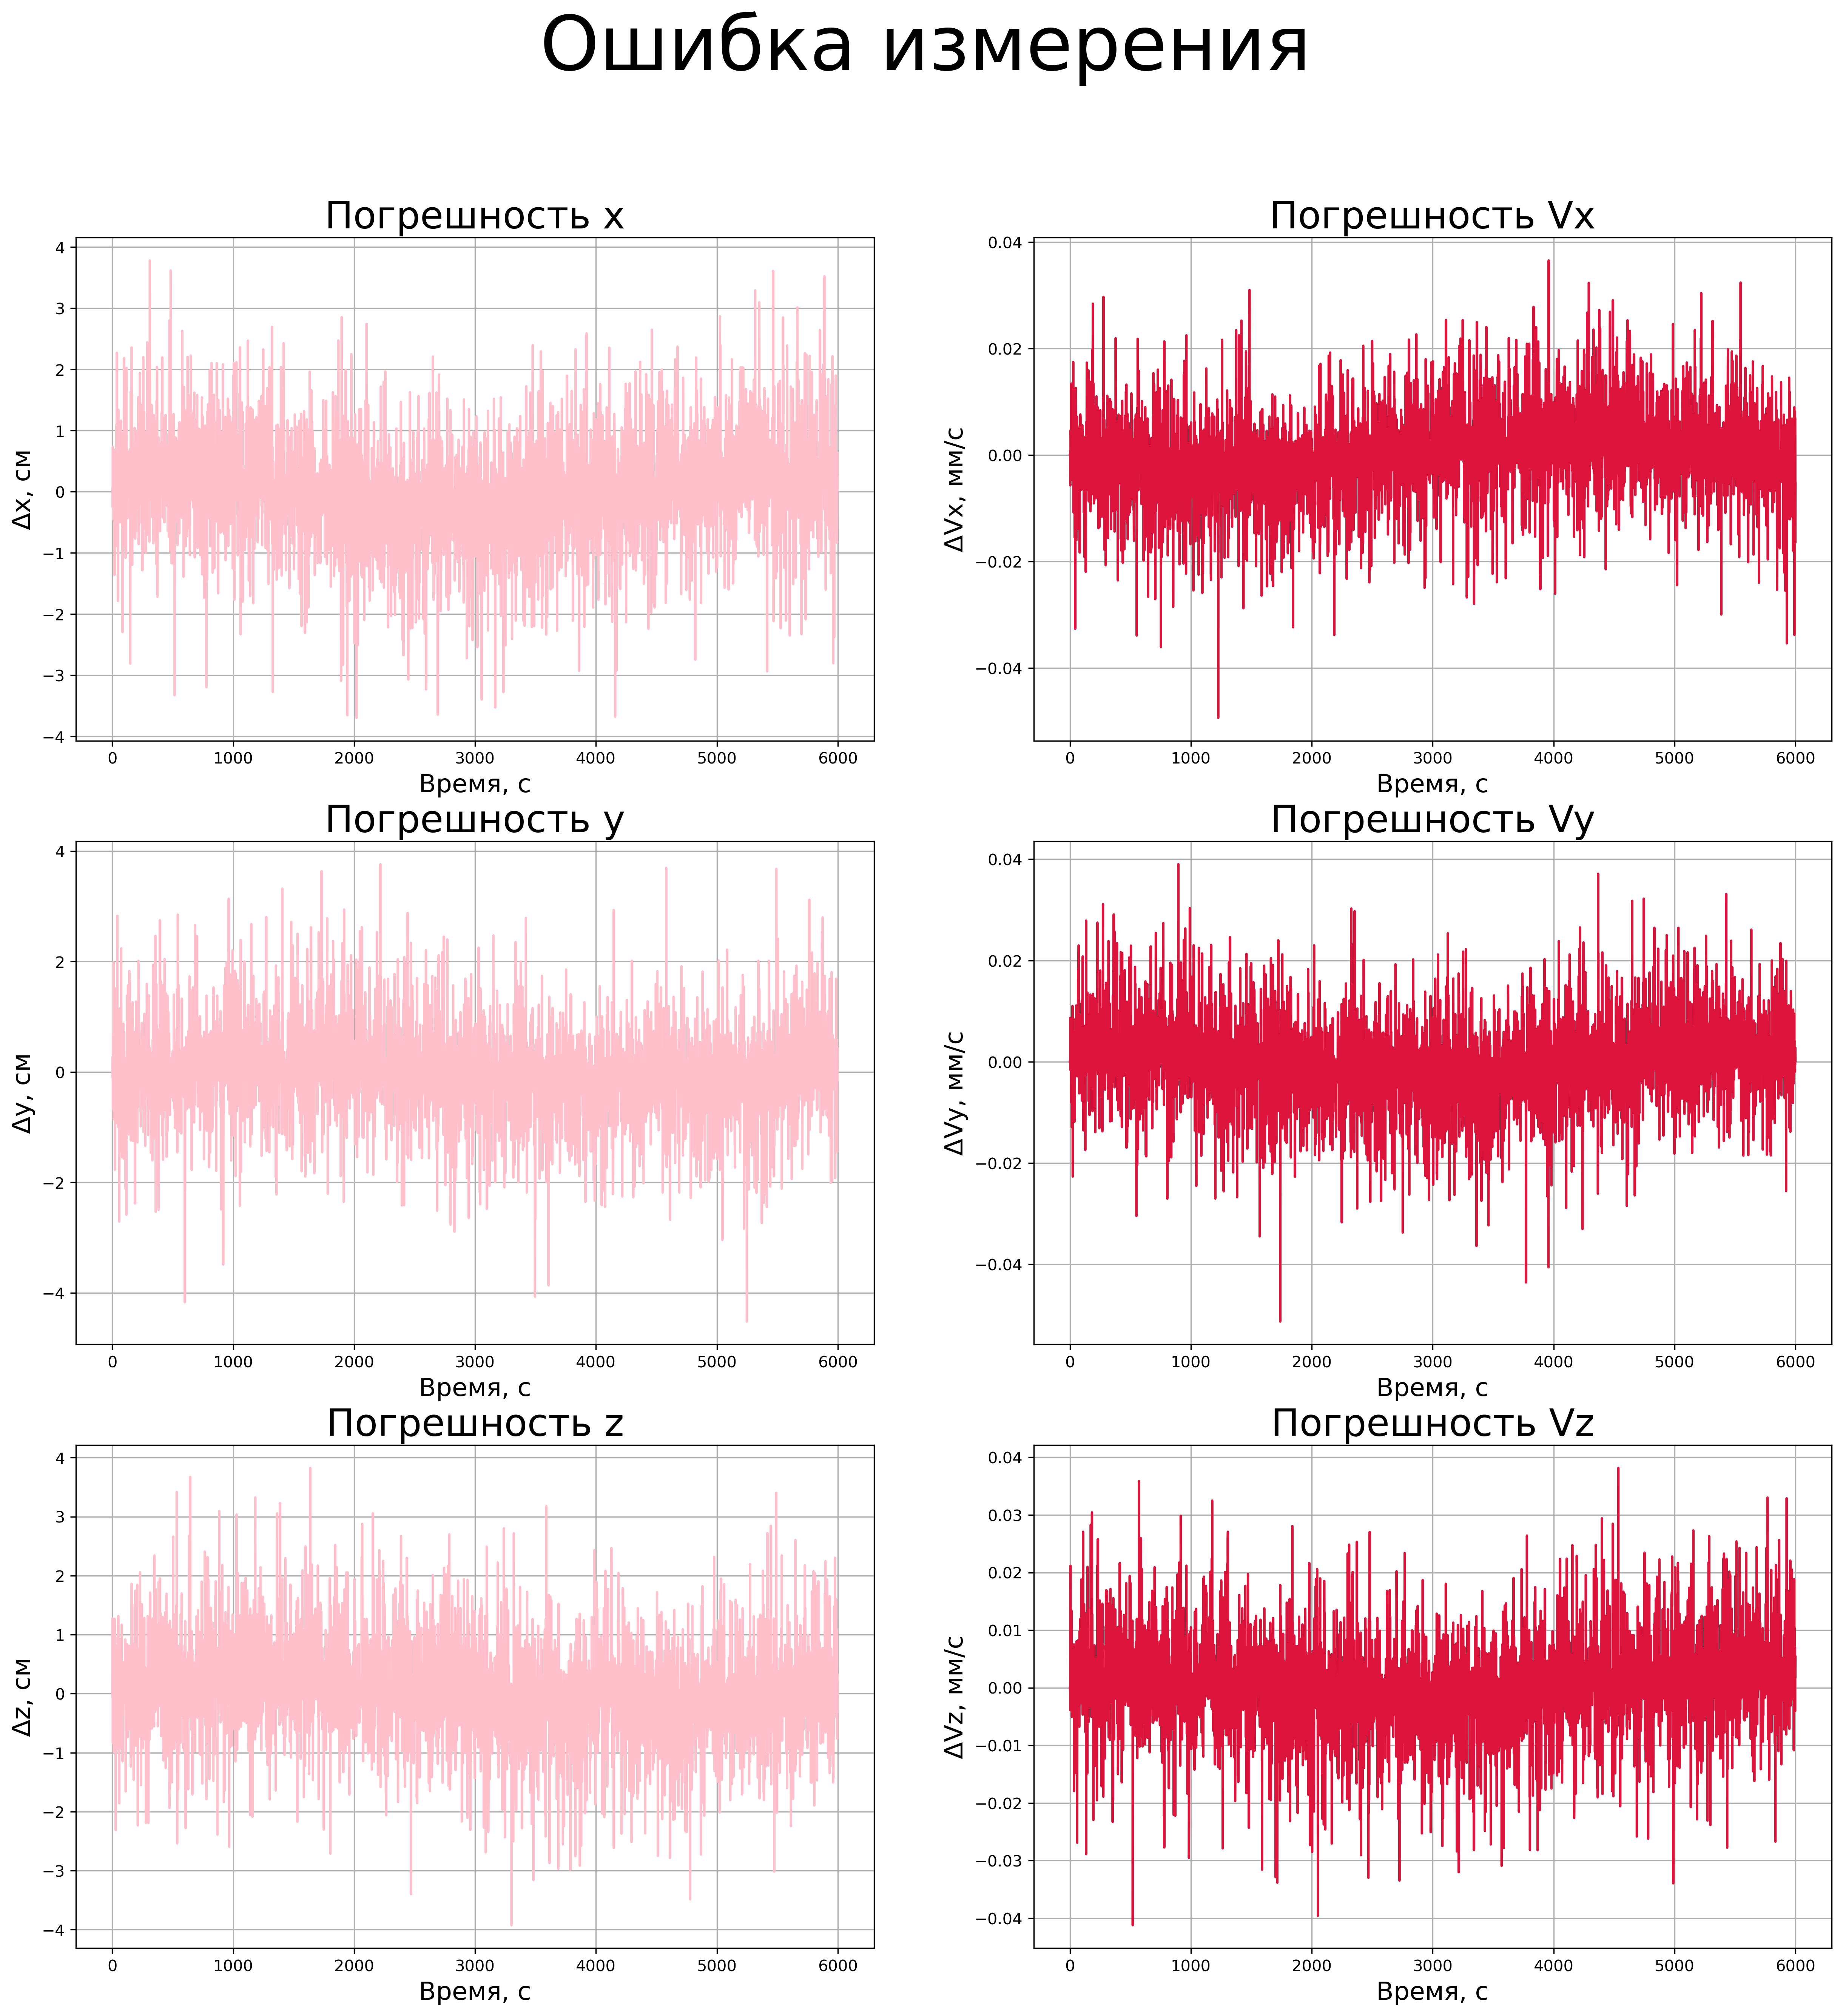

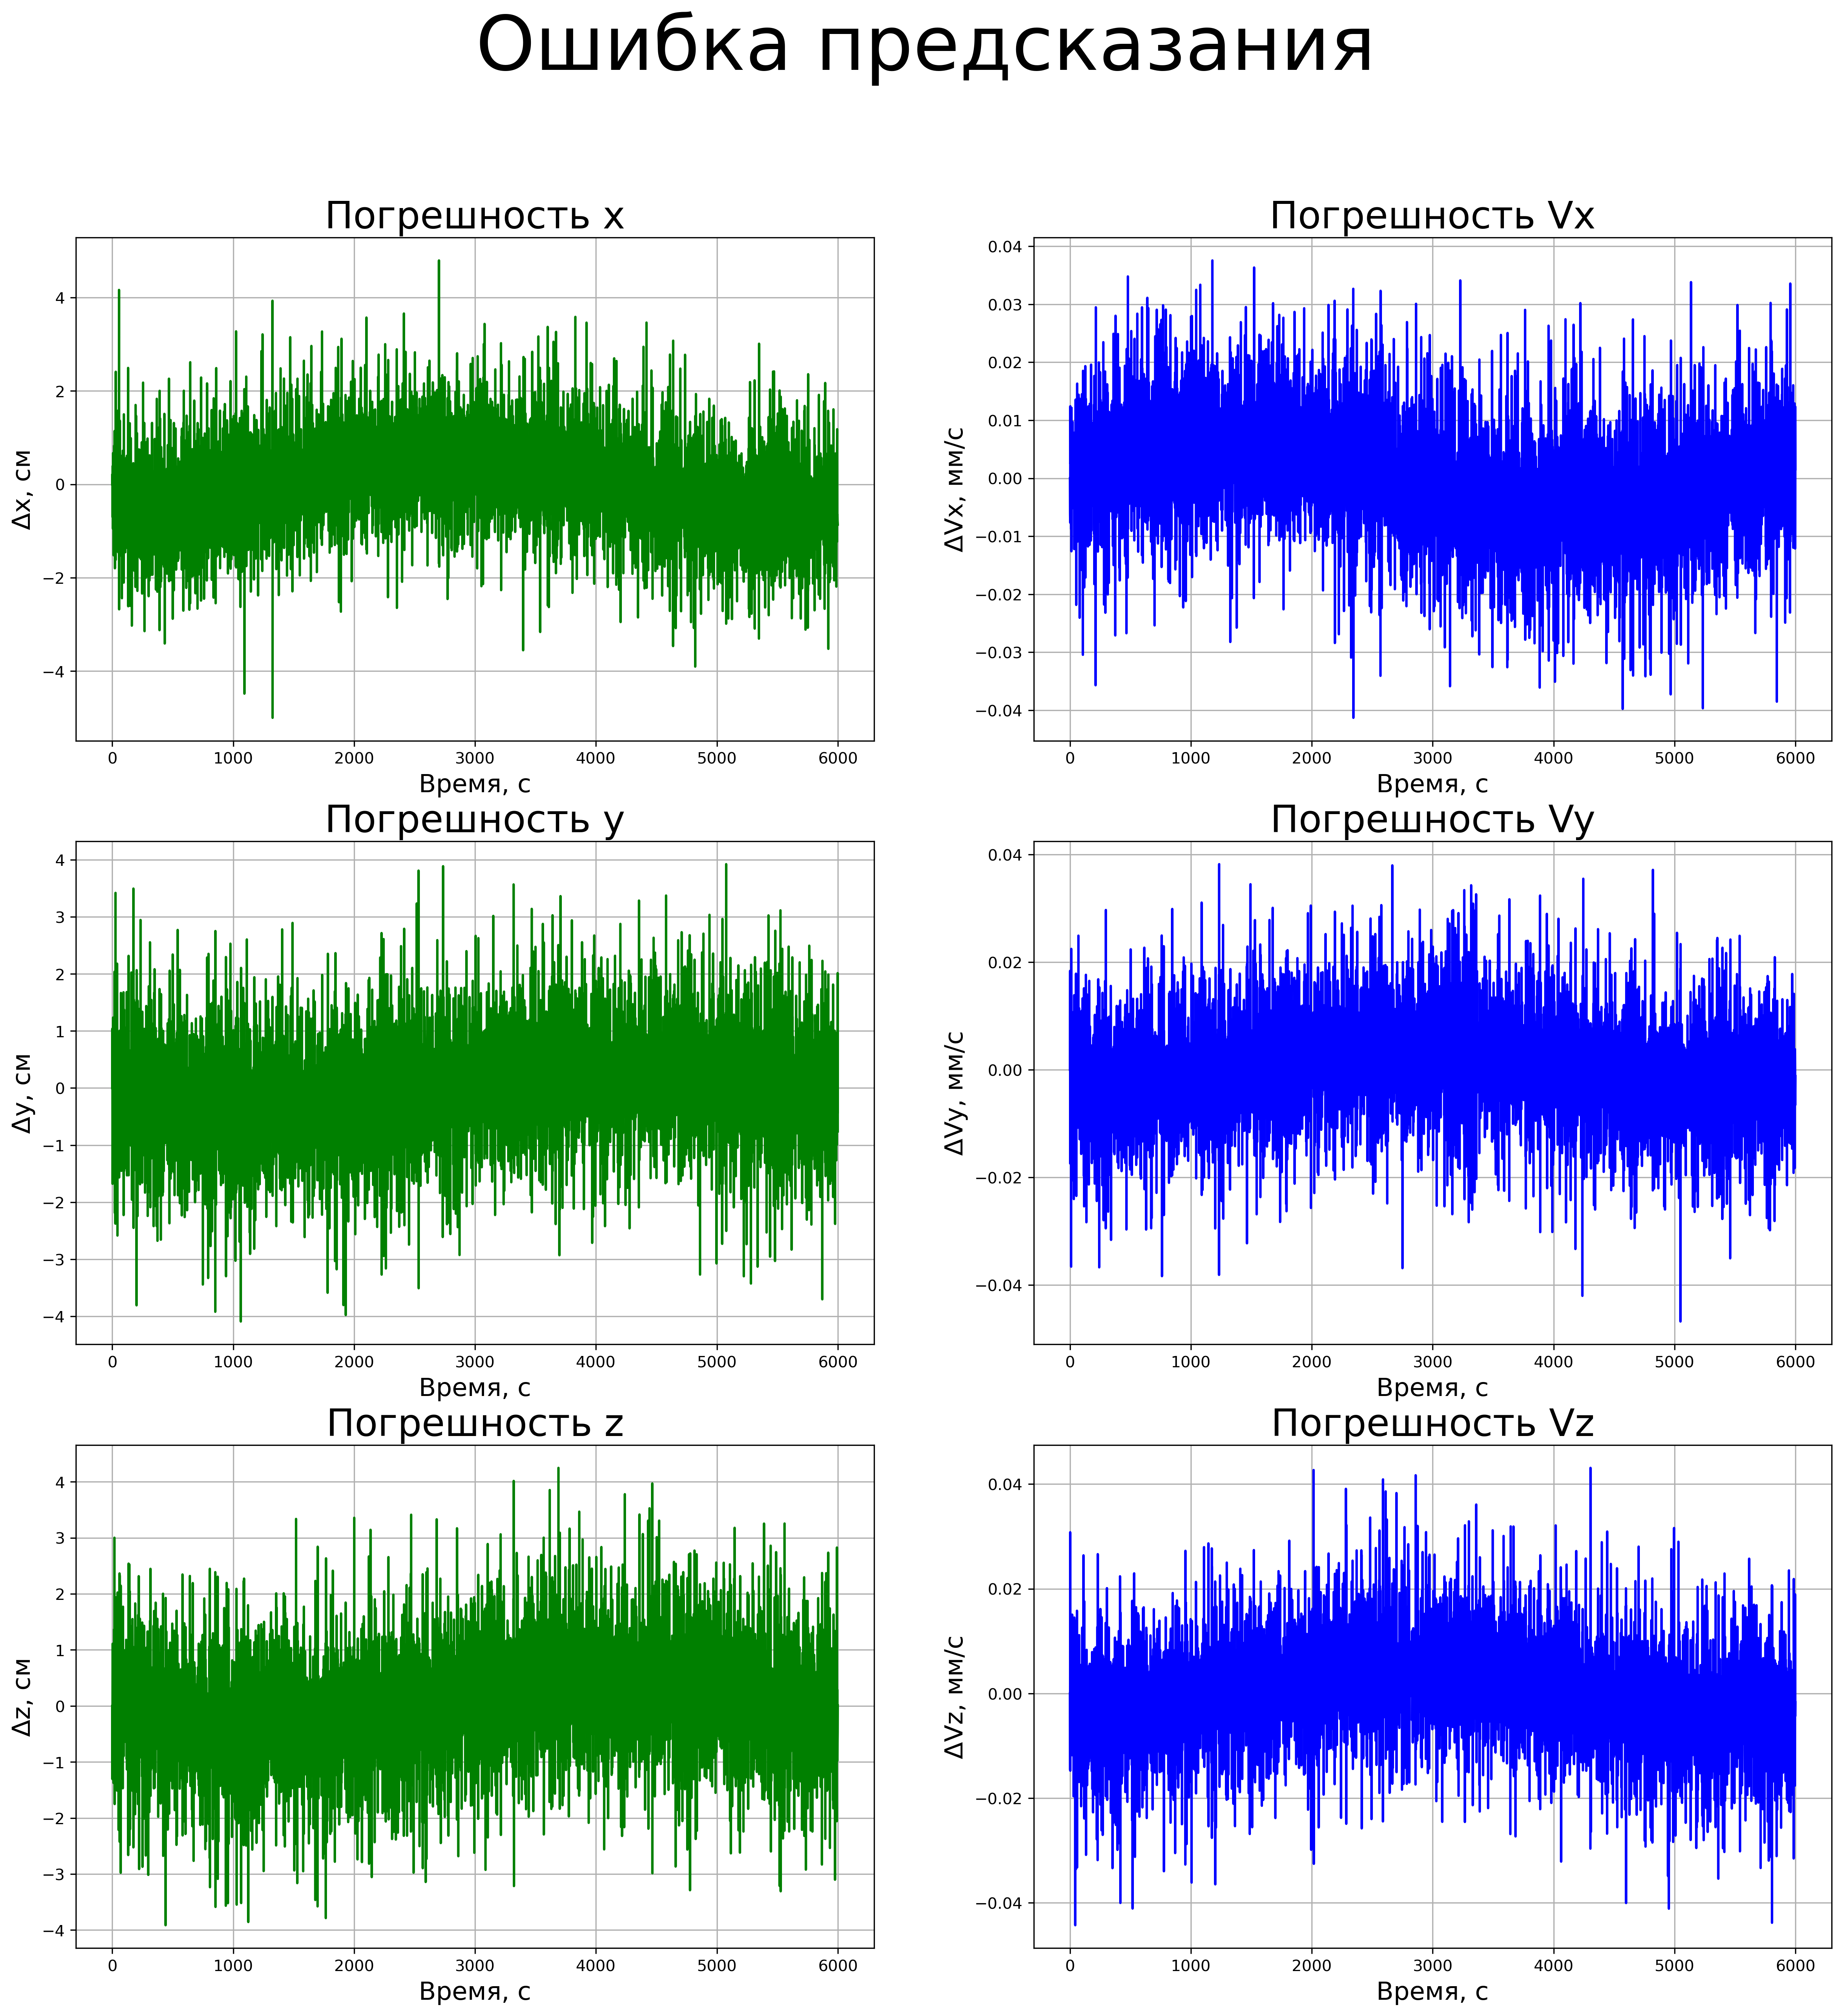

Максимальная ошибка по координате в предсказании:  0.05345961603320721
Максимальная ошибка по скорости в предсказании:  5.151541439196675e-05
Максимальная ошибка по координате в измерении:  0.04585188037205435
Максимальная ошибка по скорости в измерении:  5.431420204701483e-05
Максимальная ошибка по координате в оценке состояния:  0.03965595842509397
Максимальная ошибка по скорости в оценке состояния:  3.999901325173308e-05


In [7]:
print("Y-coordinate from time:")
print(status.iloc[:, 2])

fig_XY, ax_XY = plt.subplots(figsize=(12, 12))
start = 0
end = N+1
ax_XY.plot(status.iloc[start:end, 1], status.iloc[start:end, 2], label="Состояние")
ax_XY.plot(prediction.iloc[start:end, 1], prediction.iloc[start:end, 2], label="Предсказание")
ax_XY.plot(measure.iloc[start:end, 1], measure.iloc[start:end, 2], label="Измерение")
ax_XY.set_title("Плоскость X-Y", size=36)
ax_XY.set_xlabel("X, км", size=24)
ax_XY.set_ylabel("Y, км", size=24)
Earth = Circle((0, 0), R, color='darkblue', label="Земля")
ax_XY.add_patch(Earth)
ax_XY.grid()
fig_XY.legend()

Timeline = np.array(list(map(time, data.iloc[:, 0])))
Timeline = Timeline - Timeline[0]
fig, ax = plt.subplots(3, 2, figsize=(20, 20))
fig.suptitle("Ошибка оценки состояния", size=48)
ax[0][0].plot(Timeline, (status.iloc[:, 1]-data.iloc[:, 1]) * 100)
ax[1][0].plot(Timeline, (status.iloc[:, 2]-data.iloc[:, 2]) * 100)
ax[2][0].plot(Timeline, (status.iloc[:, 3]-data.iloc[:, 3]) * 100)
ax[0][1].plot(Timeline, (status.iloc[:, 4]-data.iloc[:, 4]) * 1e3, "orange")
ax[1][1].plot(Timeline, (status.iloc[:, 5]-data.iloc[:, 5]) * 1e3, "orange")
ax[2][1].plot(Timeline, (status.iloc[:, 6]-data.iloc[:, 6]) * 1e3, "orange")
ax[0][0].set_title("Погрешность x", size=24)
ax[1][0].set_title("Погрешность y", size=24)
ax[2][0].set_title("Погрешность z", size=24)
ax[0][1].set_title("Погрешность Vx", size=24)
ax[1][1].set_title("Погрешность Vy", size=24)
ax[2][1].set_title("Погрешность Vz", size=24)
ax[0][0].set_xlabel("Время, с", size=16)
ax[0][0].set_ylabel("Δx, cм", size=16)
ax[1][0].set_xlabel("Время, с", size=16)
ax[1][0].set_ylabel("Δy, cм", size=16)
ax[2][0].set_xlabel("Время, с", size=16)
ax[2][0].set_ylabel("Δz, cм", size=16)
ax[0][1].set_xlabel("Время, с", size=16)
ax[0][1].set_ylabel("ΔVx, мм/с", size=16)
ax[1][1].set_xlabel("Время, с", size=16)
ax[1][1].set_ylabel("ΔVy, мм/с", size=16)
ax[2][1].set_xlabel("Время, с", size=16)
ax[2][1].set_ylabel("ΔVz, мм/с", size=16)
for i in range(3):
    for j in range(2):
        ax[i][j].grid()

fig1, ax1 = plt.subplots(3, 2, figsize=(20, 20))
fig1.suptitle("Ошибка измерения", size=48)
ax1[0][0].plot(Timeline, (measure.iloc[:, 1]-status.iloc[:, 1]) * 100, "pink")
ax1[1][0].plot(Timeline, (measure.iloc[:, 2]-status.iloc[:, 2]) * 100, "pink")
ax1[2][0].plot(Timeline, (measure.iloc[:, 3]-status.iloc[:, 3]) * 100, "pink")
ax1[0][1].plot(Timeline, (measure.iloc[:, 4]-status.iloc[:, 4]) * 1e3, "crimson")
ax1[1][1].plot(Timeline, (measure.iloc[:, 5]-status.iloc[:, 5]) * 1e3, "crimson")
ax1[2][1].plot(Timeline, (measure.iloc[:, 6]-status.iloc[:, 6]) * 1e3, "crimson")
ax1[0][0].set_title("Погрешность x", size=24)
ax1[1][0].set_title("Погрешность y", size=24)
ax1[2][0].set_title("Погрешность z", size=24)
ax1[0][1].set_title("Погрешность Vx", size=24)
ax1[1][1].set_title("Погрешность Vy", size=24)
ax1[2][1].set_title("Погрешность Vz", size=24)
ax1[0][0].set_xlabel("Время, с", size=16)
ax1[0][0].set_ylabel("Δx, cм", size=16)
ax1[1][0].set_xlabel("Время, с", size=16)
ax1[1][0].set_ylabel("Δy, cм", size=16)
ax1[2][0].set_xlabel("Время, с", size=16)
ax1[2][0].set_ylabel("Δz, cм", size=16)
ax1[0][1].set_xlabel("Время, с", size=16)
ax1[0][1].set_ylabel("ΔVx, мм/с", size=16)
ax1[1][1].set_xlabel("Время, с", size=16)
ax1[1][1].set_ylabel("ΔVy, мм/с", size=16)
ax1[2][1].set_xlabel("Время, с", size=16)
ax1[2][1].set_ylabel("ΔVz, мм/с", size=16)
for i in range(3):
    for j in range(2):
        ax1[i][j].grid()

fig2, ax2 = plt.subplots(3, 2, figsize=(20, 20))
fig2.suptitle("Ошибка предсказания", size=48)
ax2[0][0].plot(Timeline, (prediction.iloc[:, 1]-status.iloc[:, 1]) * 100, "green")
ax2[1][0].plot(Timeline, (prediction.iloc[:, 2]-status.iloc[:, 2]) * 100, "green")
ax2[2][0].plot(Timeline, (prediction.iloc[:, 3]-status.iloc[:, 3]) * 100, "green")
ax2[0][1].plot(Timeline, (prediction.iloc[:, 4]-status.iloc[:, 4]) * 1e3, "blue")
ax2[1][1].plot(Timeline, (prediction.iloc[:, 5]-status.iloc[:, 5]) * 1e3, "blue")
ax2[2][1].plot(Timeline, (prediction.iloc[:, 6]-status.iloc[:, 6]) * 1e3, "blue")
ax2[0][0].set_title("Погрешность x", size=24)
ax2[1][0].set_title("Погрешность y", size=24)
ax2[2][0].set_title("Погрешность z", size=24)
ax2[0][1].set_title("Погрешность Vx", size=24)
ax2[1][1].set_title("Погрешность Vy", size=24)
ax2[2][1].set_title("Погрешность Vz", size=24)
ax2[0][0].set_xlabel("Время, с", size=16)
ax2[0][0].set_ylabel("Δx, см", size=16)
ax2[1][0].set_xlabel("Время, с", size=16)
ax2[1][0].set_ylabel("Δy, см", size=16)
ax2[2][0].set_xlabel("Время, с", size=16)
ax2[2][0].set_ylabel("Δz, см", size=16)
ax2[0][1].set_xlabel("Время, с", size=16)
ax2[0][1].set_ylabel("ΔVx, мм/с", size=16)
ax2[1][1].set_xlabel("Время, с", size=16)
ax2[1][1].set_ylabel("ΔVy, мм/с", size=16)
ax2[2][1].set_xlabel("Время, с", size=16)
ax2[2][1].set_ylabel("ΔVz, мм/с", size=16)
for i in range(3):
    for j in range(2):
        ax2[i][j].grid()

plt.show()

print("Максимальная ошибка по координате в предсказании: ", max_norm[0])
print("Максимальная ошибка по скорости в предсказании: ", max_norm[1])
print("Максимальная ошибка по координате в измерении: ", max_norm[2])
print("Максимальная ошибка по скорости в измерении: ", max_norm[3])
print("Максимальная ошибка по координате в оценке состояния: ", max_norm[4])
print("Максимальная ошибка по скорости в оценке состояния: ", max_norm[5])